In [6]:
import pandas as pd
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def mrrmse(de_test_X, prediction, threshold=-np.log(0.0001)):
    mean_rowwise_rmse = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_rmse += np.sqrt((diff**2).mean())
    mean_rowwise_rmse /= de_test_X.shape[0]
    return mean_rowwise_rmse

In [39]:
def cosine_similarity(de_test_X, prediction, threshold=-np.log(0.0001)):
    mean_cosine_similarity = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            y_i = np.clip(de_test_X[i,], -threshold, threshold)
            y_hat_i = np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            y_i = de_test_X[i,]
            y_hat_i = prediction.iloc[i]
    
        dot_product = np.dot(y_i, y_hat_i)
    
        norm_y_i = np.linalg.norm(y_i)
        norm_y_hat_i = np.linalg.norm(y_hat_i)
    
        cosine_similarity = dot_product / (norm_y_i * norm_y_hat_i)
    
        mean_cosine_similarity += cosine_similarity
    
    mean_cosine_similarity /= de_test_X.shape[0]
    return mean_cosine_similarity

In [40]:
# path to the the resources directory
path_to_data = "../../task-dge-perturbation-prediction/resources/"
path_to_results = os.path.join(path_to_data, "runs/run_2024-05-21_02-14-03")

In [41]:
de_test_kaggle = pd.read_parquet(os.path.join(path_to_data, "neurips-2023-kaggle", "de_test.parquet")).set_index("id")
de_test = pd.read_parquet(os.path.join(path_to_data, "neurips-2023-data", "de_test.parquet")).set_index("id")

In [42]:
with open(os.path.join(path_to_results, "score_uns.yaml"), 'r') as file:
    data = yaml.safe_load(file)

# Generate paths
rows = []
for entry in data:
    dataset_id = entry['dataset_id']
    method_id = entry['method_id']
    metric_ids = entry.get('metric_ids', [])
    metric_values = entry.get('metric_values', [])
    for index, metric_id in enumerate(metric_ids):
        metric_value = metric_values[index] if index < len(metric_values) else 'Unknown_value'
        path = f"{dataset_id}.{method_id}.{method_id}.output.parquet"
        rows.append({
                'dataset_id': dataset_id,
                'method_id': method_id,
                'metric_id': metric_id,
                'metric_value': metric_value,
                'path': path
            })

In [43]:
df = pd.DataFrame(rows)
df = df.pivot_table(
    index=['dataset_id', 'method_id', "path"],  # Columns to make unique
    columns='metric_id',                # Column to transform
    values=['metric_value', 'path'],    # Values to use for pivoting
    aggfunc='first'                     # Function to aggregate duplicate entries
)
df.reset_index(inplace=True)
# df.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df.columns]

# Optionally, clean up the column names if needed
df.rename(columns={
    'metric_value_mean_rowwise_rmse': 'mean_rowwise_rmse_value',
    'metric_value_mean_rowwise_mae': 'mean_rowwise_mae_value',
}, inplace=True)

In [44]:
df["mrrmse_magic"] = np.NaN
df["cosine_similarity_magic"] = np.NaN

In [45]:
methods_names = ["jn_ap_op2", "lstm_gru_cnn_ensemble", "nn_retraining_with_pseudolabels", "scape", "pyboost"]

In [46]:
for dataset in df.dataset_id.unique():
    if dataset == "neurips-2023-kaggle":
        de_gt = de_test_kaggle
    else:
        de_gt = de_test
    for method in df.method_id.unique():
        if method not in methods_names:
            continue
        print(dataset, method)
        print()
        cur_df = df.loc[(df.dataset_id == dataset) & (df.method_id == method)]
        if cur_df.shape[0] == 0:
            continue
        if ~np.isnan(cur_df.loc[:, "cosine_similarity_magic"]).any() and ~np.isnan(cur_df.loc[:, "mrrmse_magic"]).any():
            continue
        loaded_output = pd.read_parquet(os.path.join(path_to_results, "predictions", f"{dataset}.{method}.{method}.output.parquet")).set_index("id")
        
        MULT = 1.3
        for index, compound_gene_pred in loaded_output.iterrows():
            abs_compound_mean = abs(compound_gene_pred).mean()
            compound_gene_pred *= min(abs_compound_mean**0.6, 1)
            loaded_output.loc[index] = compound_gene_pred  
        loaded_output *= MULT
        df.loc[(df.dataset_id == dataset) & (df.method_id == method), "cosine_similarity_magic"] = cosine_similarity(de_gt.loc[:,loaded_output.columns].values, loaded_output, None)
        df.loc[(df.dataset_id == dataset) & (df.method_id == method), "mrrmse_magic"] = mrrmse(de_gt.loc[:,loaded_output.columns].values, loaded_output, None)
        df.loc[(df.dataset_id == dataset) & (df.method_id == method), "mrrmse_clipped_magic"] = mrrmse(de_gt.loc[:,loaded_output.columns].values, loaded_output, -np.log10(0.01))
        df.loc[(df.dataset_id == dataset) & (df.method_id == method), "mrrmse_clipped"] = mrrmse(de_gt.loc[:,loaded_output.columns].values, loaded_output, -np.log10(0.01))

neurips-2023-data jn_ap_op2

neurips-2023-data lstm_gru_cnn_ensemble

neurips-2023-data nn_retraining_with_pseudolabels

neurips-2023-data pyboost

neurips-2023-data scape

neurips-2023-kaggle jn_ap_op2

neurips-2023-kaggle lstm_gru_cnn_ensemble

neurips-2023-kaggle nn_retraining_with_pseudolabels

neurips-2023-kaggle pyboost

neurips-2023-kaggle scape



In [47]:
only_methods_df = df[df.method_id.isin(methods_names)]

In [48]:
new_columns = [level2 if level2 else level1 for level1, level2 in only_methods_df.columns]
# Assign the new column names to the DataFrame
only_methods_df.columns = new_columns

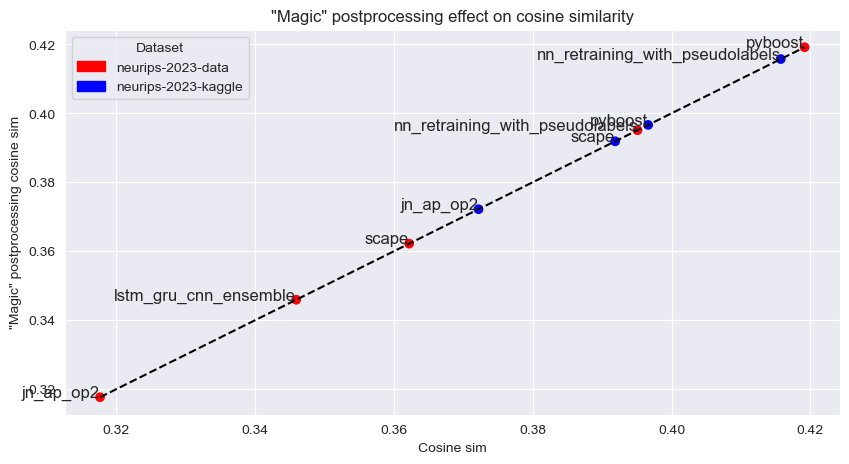

In [49]:
import matplotlib.patches as mpatches
color_map = {'neurips-2023-data': 'red', 'neurips-2023-kaggle': 'blue'}
colors = only_methods_df['dataset_id'].map(color_map)
plt.figure(figsize=(10, 5))
scatter = plt.scatter(only_methods_df['mean_cosine_sim'], only_methods_df['cosine_similarity_magic'], c=colors)
for i, point in only_methods_df.iterrows():
    plt.text(point['mean_cosine_sim'], point['cosine_similarity_magic'], str(point['method_id']), 
             fontsize=12, ha='right')

plt.title('"Magic" postprocessing effect on cosine similarity')
plt.xlabel('Cosine sim')
plt.ylabel('"Magic" postprocessing cosine sim')
max_value = max(only_methods_df['mean_cosine_sim'].max(), only_methods_df['cosine_similarity_magic'].max())
min_value = min(only_methods_df['mean_cosine_sim'].min(), only_methods_df['cosine_similarity_magic'].min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_handles, title="Dataset")
plt.grid(True)
plt.show()

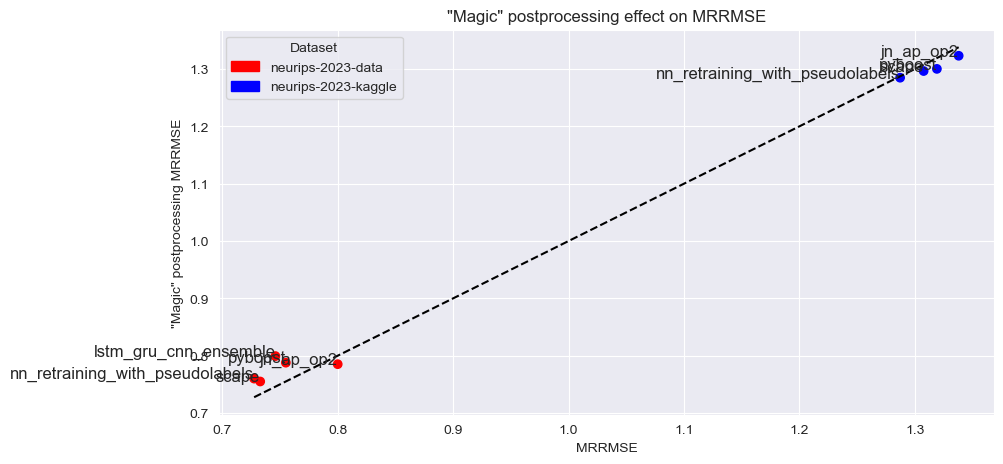

In [50]:
import matplotlib.patches as mpatches
color_map = {'neurips-2023-data': 'red', 'neurips-2023-kaggle': 'blue'}
colors = only_methods_df['dataset_id'].map(color_map)
plt.figure(figsize=(10, 5))
scatter = plt.scatter(only_methods_df['mean_rowwise_rmse'], only_methods_df['mrrmse_magic'], c=colors)
for i, point in only_methods_df.iterrows():
    plt.text(point['mean_rowwise_rmse'], point['mrrmse_magic'], str(point['method_id']), 
             fontsize=12, ha='right')

plt.title('"Magic" postprocessing effect on MRRMSE')
plt.xlabel('MRRMSE')
plt.ylabel('"Magic" postprocessing MRRMSE')
max_value = max(only_methods_df['mean_rowwise_rmse'].max(), only_methods_df['mrrmse_magic'].max())
min_value = min(only_methods_df['mean_rowwise_rmse'].min(), only_methods_df['mrrmse_magic'].min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_handles, title="Dataset")
plt.grid(True)
plt.show()

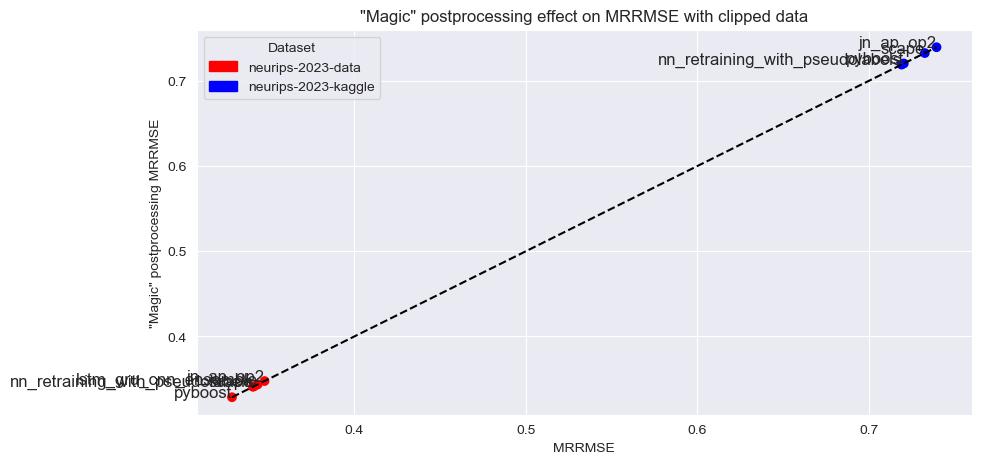

In [51]:
color_map = {'neurips-2023-data': 'red', 'neurips-2023-kaggle': 'blue'}
colors = only_methods_df['dataset_id'].map(color_map)
plt.figure(figsize=(10, 5))
scatter = plt.scatter(only_methods_df['mrrmse_clipped'], only_methods_df['mrrmse_clipped_magic'], c=colors)
for i, point in only_methods_df.iterrows():
    plt.text(point['mrrmse_clipped'], point['mrrmse_clipped_magic'], str(point['method_id']), 
             fontsize=12, ha='right')

plt.title('"Magic" postprocessing effect on MRRMSE with clipped data')
plt.xlabel('MRRMSE')
plt.ylabel('"Magic" postprocessing MRRMSE')
max_value = max(only_methods_df['mrrmse_clipped'].max(), only_methods_df['mrrmse_clipped_magic'].max())
min_value = min(only_methods_df['mrrmse_clipped'].min(), only_methods_df['mrrmse_clipped_magic'].min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
plt.legend(handles=legend_handles, title="Dataset")
plt.grid(True)
plt.show()

In [36]:
# conclusion: postprocessing of the results that brings predictions closer to 1 and clips the values to 1 sligthly improved the predictions on the kaggle dataset, but had detrimental effect on the updated one in MRRMSE. It had close to no effect on cosine similarity.

# MULT = 1.3
# for index, compound_gene_pred in loaded_output.iterrows():
#     abs_compound_mean = abs(compound_gene_pred).mean()
#     compound_gene_pred *= min(abs_compound_mean**0.6, 1)
#     loaded_output.loc[index] = compound_gene_pred  
# loaded_output *= MULT

In [37]:
only_methods_df

,dataset_id,method_id,path,mean_cosine_sim,mean_rowwise_mae,mean_rowwise_rmse,mrrmse_magic,cosine_similarity_magic,mrrmse_clipped_magic,mrrmse_clipped
1,neurips-2023-data,jn_ap_op2,neurips-2023-data.jn_ap_op2.jn_ap_op2.output.p...,0.317641,0.308450,0.799885,0.785095,0.317641,0.347706,0.347706
2,neurips-2023-data,lstm_gru_cnn_ensemble,neurips-2023-data.lstm_gru_cnn_ensemble.lstm_g...,0.345916,0.279354,0.745904,0.799196,0.345916,0.343641,0.343641
6,neurips-2023-data,nn_retraining_with_pseudolabels,neurips-2023-data.nn_retraining_with_pseudolab...,0.395099,0.286526,0.727440,0.759927,0.395099,0.341627,0.341627
7,neurips-2023-data,pyboost,neurips-2023-data.pyboost.pyboost.output.parquet,0.419177,0.267863,0.754943,0.787695,0.419177,0.328731,0.328731
9,neurips-2023-data,scape,neurips-2023-data.scape.scape.output.parquet,0.362193,0.288135,0.732711,0.754888,0.362193,0.340966,0.340966
13,neurips-2023-kaggle,jn_ap_op2,neurips-2023-kaggle.jn_ap_op2.jn_ap_op2.output...,0.372184,0.865429,1.338076,1.323197,0.372184,0.739379,0.739379
17,neurips-2023-kaggle,nn_retraining_with_pseudolabels,neurips-2023-kaggle.nn_retraining_with_pseudol...,0.415742,0.826261,1.287327,1.284880,0.415742,0.718995,0.718995
18,neurips-2023-kaggle,pyboost,neurips-2023-kaggle.pyboost.pyboost.output.par...,0.396637,0.830109,1.319200,1.300293,0.396637,0.720307,0.720307
20,neurips-2023-kaggle,scape,neurips-2023-kaggle.scape.scape.output.parquet,0.391884,0.850036,1.307703,1.296557,0.391884,0.732537,0.732537
